In [13]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [14]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [15]:
colab_flag = True

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [16]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [17]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/KS


In [19]:
from tools.misc_tools import plot_reconstructed_data_KS, plot_latent_states_KS
from tools.ae_v3 import Autoencoder

In [20]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[]


In [21]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
2.9.2


# KS System

In [22]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

In [23]:
from numpy import *

data_dir_idx = '001'

dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data_og = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']

normalize_flag_ogdata: False


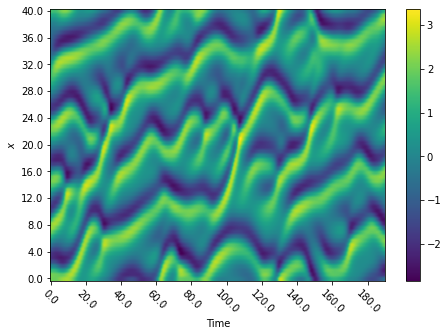

In [24]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data_og,
    xgrid)

In [25]:
dir_name_all_ae = os.getcwd()+'{ds}saved_ae'.format(ds=dir_sep)
dir_contents_list = os.listdir(dir_name_all_ae)
chosen_dir_list = []
for elem in dir_contents_list:
    dir_name_ae = dir_name_all_ae + dir_sep + elem
    if os.path.isdir(dir_name_ae):
        with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
            lines = f.readlines()
            params_dict = eval(''.join(lines))
            if data_dir_idx == params_dict['data_dir_idx']:
                chosen_dir_list.append(elem)

print('chosen_dir_list:', chosen_dir_list)

chosen_dir_list: ['ae_000', 'ae_002', 'ae_003', 'ae_005', 'ae_007', 'ae_009', 'ae_011', 'ae_014']


In [26]:
num_latent_states_list = []
ae_RMSEavg_list = []

for elem in chosen_dir_list:
    print('\n\n-------------------- {} --------------------'.format(elem))
    dir_name_ae = dir_name_all_ae + dir_sep + elem
    # reading simulation parameters
    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()
    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']

    # delaing with normalizing the data before feeding into autoencoder
    all_data = all_data_og
    if normalizeforae_flag == True:
        all_data = all_data_og.copy()
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

    # create data
    latent_states_all = ae_net.encoder_net.predict(all_data)
    num_latent_states = latent_states_all.shape[1]
    num_latent_states_list.append(num_latent_states)

    plot_latent_states_KS(
        boundary_idx_arr,
        latent_states_all,
        delta_t,
        dir_name_ae,
        xticks_snapto=20,
        num_yticks=11,
        save_figs=False)
    
    reconstructed_data = ae_net.predict(all_data)

    plot_reconstructed_data_KS(
        boundary_idx_arr,
        dir_name_ae,
        all_data,
        reconstructed_data, delta_t, xgrid,
        save_figs=False,
        normalization_constant_arr=normalization_constant_arr_aedata,
        xticks_snapto=20,
        num_yticks=11)

    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] *= normalization_constant_arr_aedata[1, i]
            all_data[:, i] += normalization_constant_arr_aedata[0, i]
            reconstructed_data[:, i] *= normalization_constant_arr_aedata[1, i]
            reconstructed_data[:, i] += normalization_constant_arr_aedata[0, i]
    
    RMSEavg = np.mean(np.mean((all_data[:, 0:xgrid.shape[0]] - reconstructed_data[:, 0:xgrid.shape[0]])**2, axis=1)**0.5)
    ae_RMSEavg_list.append(RMSEavg)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
sorted_idx = np.argsort(num_latent_states_list)
num_latent_states_list = np.array(num_latent_states_list)[sorted_idx]
ae_RMSEavg_list = np.array(ae_RMSEavg_list)[sorted_idx]
chosen_dir_list = np.array(chosen_dir_list)[sorted_idx]

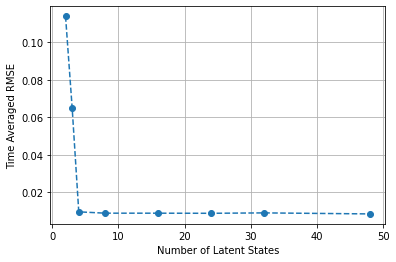

In [28]:
plt.plot(num_latent_states_list, ae_RMSEavg_list, '--', marker='o')
plt.grid(True)
plt.xlabel('Number of Latent States')
plt.ylabel('Time Averaged RMSE')
plt.show()

# POD

In [29]:
cov_matrix = all_data[:, 0:xgrid.shape[0]].transpose() @ all_data[:, 0:xgrid.shape[0]]
cov_matrix /= xgrid.shape[0]-1

In [30]:
eigenvals, eigenvecs = linalg.eig(cov_matrix)

In [31]:
sorted_idx = np.argsort(eigenvals)
eigenvals = eigenvals[sorted_idx]
eigenvecs = eigenvecs[:, sorted_idx]

In [32]:
pod_RMSEavg_list = []

for num_latent_states in num_latent_states_list:
    # num_latent_states = num_latent_states_list[i]
    Wl = eigenvecs[:, -num_latent_states:]
    Xl = all_data[:, 0:xgrid.shape[0]] @ Wl @ Wl.transpose()
    RMSEavg = np.mean(np.mean((all_data[:, 0:xgrid.shape[0]] - Xl)**2, axis=1)**0.5)
    pod_RMSEavg_list.append(RMSEavg)

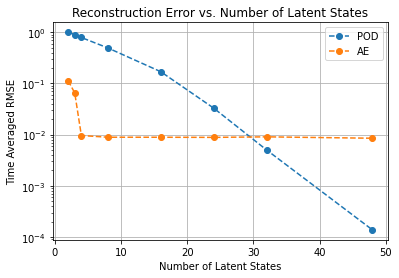

In [34]:
plt.semilogy(num_latent_states_list, pod_RMSEavg_list, '--', marker='o')
plt.semilogy(num_latent_states_list, ae_RMSEavg_list, '--', marker='o')
plt.legend(['POD', 'AE'])
plt.grid(True)
plt.xlabel('Number of Latent States')
plt.ylabel('Time Averaged RMSE')
plt.title('Reconstruction Error vs. Number of Latent States', size=12)
# plt.savefig(dir_name_all_ae+dir_sep+'AE_vs_POD.png', dpi=300, bbox_inches='tight')
plt.show()